## [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [233]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Micrograd Classes and Functions

In [234]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [235]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [236]:
import random

class Neuron:
    
    def __init__(self, nin):
#### my add ##########################################        
        # random.seed(12345)  # WARNING: all neurons will have the same weights and bias
######################################################        
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Neuron in Neural Network
<!-- ### Simple Neural Network: Single Neuron with 3 Inputs -->
<img src="..\karpathy\img\Nertual_Network_1_Neuron_3_Inputs.png">

#### Activation Function: Tanh

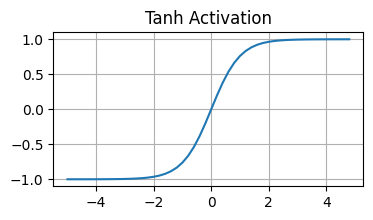

In [237]:
_num = np.arange(-5, 5, 0.2)
plt.figure(figsize=(4, 2))
plt.plot(_num, np.tanh(_num))
plt.title("Tanh Activation")
plt.grid()

##### Calculate Output with Forward Pass

In [238]:
# inputs
x0 = Value(-3.0, label='x0')
x1 = Value(0.0, label='x1')
x2 = Value(0.5, label='x2')

# weights
w0 = Value(2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(4.618626415, label='b')

# forward pass
# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_0 = n.tanh(); out_0.label = 'out_0'
print(f'neuron output: {out_0.data}')

neuron output: -0.7071067801767762


##### Calculate Gradient with Backward Pass

w0.grad(i.e. d(output)/d(w0)): -1.500000004284097


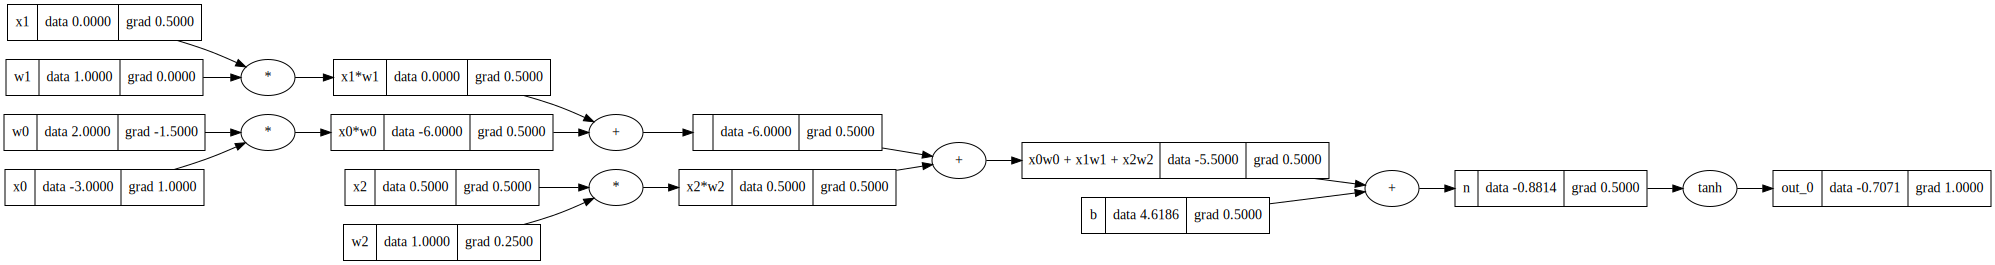

In [239]:
# backward pass to calculate gradient
out_0.backward()
  
out_0_grad = w0.grad  # store w0.grad, further calculation with w0 will reset w0.grad to zero
print(f'w0.grad(i.e. d(output)/d(w0)): {w0.grad}')
draw_dot(out_0)

##### Check Backward Pass Gradient Calculation: d(output) / d(x0)

In [240]:
h = 0.000001
w0 += h  # increment x0 by h

# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_1 = n.tanh(); out_1.label = 'out_1'
out_grad = (out_1 - out_0) / h 

print(f'---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----')
print(f'out_1: {out_1.data:<12.10f}, out_0: {out_0.data:<12.10f}, d(out): {out_1.data-out_0.data:<12.10f}, d(w0): {h:<12.10f}, d(out)/d(w0): {(out_1.data-out_0.data)/h:<12.10f}')
print(f'd(out) / d(w0):             {out_grad.data:<12.10f}')
print(f'w0.grad from backward pass: {out_0_grad:<12.10f}')

---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----
out_1: -0.7071082802, out_0: -0.7071067802, d(out): -0.0000015000, d(w0): 0.0000010000, d(out)/d(w0): -1.4999968224
d(out) / d(w0):             -1.4999968224
w0.grad from backward pass: -1.5000000043


##### Check Output and Gradient Calculation with PyTorch

In [241]:
import torch

In [242]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <--')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <--')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <--
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <--


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [243]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [244]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'len(n.parameters()): {len(n.parameters())}')
# n.parameters()
for i, v in enumerate(n.parameters()):
  print(f'i: {i:>2}, {v.data:>14.10f}')

len(n.parameters()): 41
i:  0,  -0.0952690735
i:  1,   0.3679387872
i:  2,   0.9316894304
i:  3,   0.4807952497
i:  4,  -0.1278204536
i:  5,   0.7633232397
i:  6,   0.1105173324
i:  7,   0.5484646896
i:  8,   0.3070391659
i:  9,   0.1673682275
i: 10,   0.0757392934
i: 11,   0.2194152612
i: 12,  -0.7117225967
i: 13,  -0.6519255363
i: 14,   0.7322786608
i: 15,   0.7699393888
i: 16,   0.5167810851
i: 17,   0.2847722259
i: 18,  -0.7121525570
i: 19,  -0.5845793008
i: 20,  -0.9292181697
i: 21,   0.6099217977
i: 22,  -0.2605157380
i: 23,   0.1771300226
i: 24,  -0.4989551381
i: 25,  -0.5952030994
i: 26,   0.4611598036
i: 27,   0.9232751882
i: 28,  -0.7898806706
i: 29,  -0.5116289431
i: 30,  -0.6633367809
i: 31,  -0.5473370018
i: 32,  -0.1372456003
i: 33,  -0.6384022579
i: 34,  -0.9340299413
i: 35,  -0.7743634475
i: 36,   0.5358277663
i: 37,   0.8758098765
i: 38,   0.9368674906
i: 39,   0.2332465746
i: 40,  -0.1207504561


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [245]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [246]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}')
        print(f'b_mat:  {b_mat}')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('----')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
neuron 0
w0: -0.0952691,   w0.grad:  0.0000000
w1:  0.3679388,   w1.grad:  0.0000000
w2:  0.9316894,   w2.grad:  0.0000000
b:   0.4807952
b_mat:  [0.48079524973212573]
neuron 1
w0: -0.1278205,   w0.grad:  0.0000000
w1:  0.7633232,   w1.grad:  0.0000000
w2:  0.1105173,   w2.grad:  0.0000000
b:   0.5484647
b_mat:  [0.48079524973212573, 0.5484646895629972]
neuron 2
w0:  0.3070392,   w0.grad:  0.0000000
w1:  0.1673682,   w1.grad:  0.0000000
w2:  0.0757393,   w2.grad:  0.0000000
b:   0.2194153
b_mat:  [0.48079524973212573, 0.5484646895629972, 0.2194152611754807]
neuron 3
w0: -0.7117226,   w0.grad:  0.0000000
w1: -0.6519255,   w1.grad:  0.0000000
w2:  0.7322787,   w2.grad:  0.0000000
b:   0.7699394
b_mat:  [0.48079524973212573, 0.5484646895629972, 0.2194152611754807, 0.7699393887704105]
----
layer: 1, neuron_cnt: 4
----
neuron 0
w0:  0.5167811,   w0.grad:  0.0000000
w1:  0.2847722,   w1.grad:  0.0000000
w2: -0.7121526,   w2.grad:  0.0000000
w3: -0.5

##### Print Neural Network's Weights and Biases Matrices

In [247]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat:\n{w_n_b[0]}')
  print(f'b_mat:\n{w_n_b[1]}\n')  
    

i: 0
w_mat:
[[-0.09526907  0.36793879  0.93168943]
 [-0.12782045  0.76332324  0.11051733]
 [ 0.30703917  0.16736823  0.07573929]
 [-0.7117226  -0.65192554  0.73227866]]
b_mat:
[[0.48079525 0.54846469 0.21941526 0.76993939]]

i: 1
w_mat:
[[ 0.51678109  0.28477223 -0.71215256 -0.5845793 ]
 [ 0.6099218  -0.26051574  0.17713002 -0.49895514]
 [ 0.4611598   0.92327519 -0.78988067 -0.51162894]
 [-0.547337   -0.1372456  -0.63840226 -0.93402994]]
b_mat:
[[-0.92921817 -0.5952031  -0.66333678 -0.77436345]]

i: 2
w_mat:
[[0.53582777 0.87580988 0.93686749 0.23324657]]
b_mat:
[[-0.12075046]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [248]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])
  output = np.tanh(np.matmul(weights, input) + bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')    
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[-0.09526907  0.36793879  0.93168943]
 [-0.12782045  0.76332324  0.11051733]
 [ 0.30703917  0.16736823  0.07573929]
 [-0.7117226  -0.65192554  0.73227866]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

bias (4, 1):
[[0.48079525]
 [0.54846469]
 [0.21941526]
 [0.76993939]]

output (4, 2):
[[ 0.43202527  0.28479623]
 [ 0.98585653 -0.49530172]
 [ 0.85102523  0.76618942]
 [-0.9974994  -0.33385763]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[ 0.51678109  0.28477223 -0.71215256 -0.5845793 ]
 [ 0.6099218  -0.26051574  0.17713002 -0.49895514]
 [ 0.4611598   0.92327519 -0.78988067 -0.51162894]
 [-0.547337   -0.1372456  -0.63840226 -0.93402994]]

input (4, 2):
[[ 0.43202527  0.28479623]
 [ 0.98585653 -0.49530172]
 [ 0.85102523  0.76618942]
 [-0.9974994  -0.33385763]]

bias (4, 1):
[[-0.92921817]
 [-0.5952031 ]
 [-0.66333678]
 [-0.77436345]]

output (4, 2):
[[-0.42037993 -0.85

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [249]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [-0.18141505462832805, -0.9194876545967469]
ys:                 [1.0, -1.0]
loss_data:          1.4022237690647879


#### Micrograd backward pass and update parameters

In [250]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.0952690735    -3.9840132700           0.05000         0.1039315900
  1      0.3679387872    -6.0574932664           0.05000         0.6708134505
  2      0.9316894304     2.0216333119           0.05000         0.8306077648
  3      0.4807952497    -1.9994133042           0.05000         0.5807659149
  4     -0.1278204536    -0.0881870322           0.05000        -0.1234111020
  5      0.7633232397    -0.1301716135           0.05000         0.7698318204
  6      0.1105173324     0.0433266307           0.05000         0.1083510009
  7      0.5484646896    -0.0439017948           0.05000         0.5506597793
  8      0.3070391659     1.1681575710           0.05000         0.2486312873
  9      0.1673682275     1.7612730881           0.05000         0.0793045731
 10      0.0757392934    -0.5873648697           0.05000         0.1051075369
 11      0.2194152612     0.5849003066

### Improve Prediction with Parameter Iteration 

In [251]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.8541020624483188), Value(data = -0.7623896006323063)]
step: 0, loss: 0.07774491006950916
-------
ypred: [Value(data = 0.8544159381585993), Value(data = -0.8163606661868883)]
step: 1, loss: 0.054918123985564254
-------
ypred: [Value(data = 0.8576769341825883), Value(data = -0.843750813721096)]
step: 2, loss: 0.044669663276486964
-------
ypred: [Value(data = 0.8617611617511163), Value(data = -0.8613940975288775)]
step: 3, loss: 0.03832157260023535
-------
ypred: [Value(data = 0.866027292769352), Value(data = -0.874052685559009)]
step: 4, loss: 0.033811412297606806
-------
ypred: [Value(data = 0.870222016374644), Value(data = -0.8837349359142657)]
step: 5, loss: 0.030359890160723074
-------
ypred: [Value(data = 0.8742393670844095), Value(data = -0.8914645856451232)]
step: 6, loss: 0.027595672960514694
-------
ypred: [Value(data = 0.8780382776437373), Value(data = -0.897828206336281)]
step: 7, loss: 0.02531373714056767
-------
ypred: [Value(data = 0.8816082894144105)

Text(0, 0.5, 'Loss')

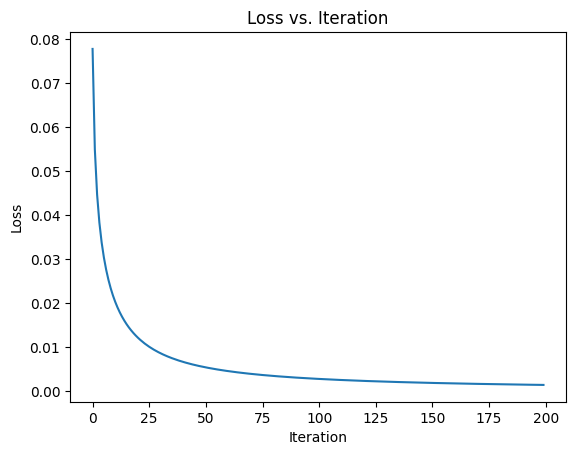

In [252]:

# Create a list of iterations
iterations = range(len(losses))

# Plot the loss as a function of iteration
plt.plot(iterations, losses)

# Add a title to the plot
plt.title('Loss vs. Iteration')

# Add labels to the x-axis and y-axis
plt.xlabel('Iteration')
plt.ylabel('Loss')

# TODO build same model with pyTorch 

In [253]:
# # create neural network and initialize weights and biases
# n = MLP(3, [4, 4, 1])

# # inputs
# xs = [
#   [2.0, 3.0, -1.0],
#   [3.0, -1.0, 0.5],
#   [5.0, -3.0, 1.5]  
# ]

# # desired targets
# ys = [1.0, -1.0, -.5]

# # learning rate (i.e. step size)
# learning_rate = 0.05

In [261]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]


# # inputs
# xs = [
#   [2.0, 3.0, -1.0],
#   [3.0, -1.0, 0.5],
#   [5.0, -3.0, 1.5]  
# ]

# # desired targets
# ys = [1.0, -1.0, -.5]

# add a dimension to the target tensor
ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

for epoch in range(1000):
    # forward pass
    outputs = model(torch.tensor(xs))

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, ys)

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} loss: {loss}")

print(f"Prediction: {model(torch.tensor(xs))}")


Epoch 0 loss: 0.896253228187561
Epoch 100 loss: 5.684341886080802e-14
Epoch 200 loss: 2.3092638912203256e-14
Epoch 300 loss: 1.4210854715202004e-14
Epoch 400 loss: 3.552713678800501e-15
Epoch 500 loss: 3.552713678800501e-15
Epoch 600 loss: 3.552713678800501e-15
Epoch 700 loss: 3.552713678800501e-15
Epoch 800 loss: 3.552713678800501e-15
Epoch 900 loss: 3.552713678800501e-15
Prediction: tensor([[ 1.0000],
        [-1.0000]], grad_fn=<AddmmBackward0>)


In [262]:
print(f'inputs.shape: {torch.tensor(xs).shape}')
print(f'inputs:\n{torch.tensor(xs)}\n')

for p in model.parameters():
  print(p.shape)
  print(p)
  print('---')

print(f'target.shape: {ys.shape}')
print(f'target:\n{ys}\n')
print(f'prediction.shape: {model(torch.tensor(xs)).shape}')
print(f'prediction:\n{model(torch.tensor(xs))}\n')


inputs.shape: torch.Size([2, 3])
inputs:
tensor([[ 2.0000,  3.0000, -1.0000],
        [ 3.0000, -1.0000,  0.5000]])

torch.Size([4, 3])
Parameter containing:
tensor([[ 0.4922, -0.2512, -0.4227],
        [ 0.3134, -0.5421,  0.4623],
        [-0.1160, -0.4052, -0.0508],
        [-0.2223, -0.2276,  0.3273]], requires_grad=True)
---
torch.Size([4])
Parameter containing:
tensor([ 0.0839, -0.2882,  0.3065, -0.2138], requires_grad=True)
---
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.0130,  0.6891,  0.3890,  0.4239],
        [-0.4375,  0.4491, -0.1910,  0.1280],
        [ 0.3163,  0.3782,  0.5352, -0.4319],
        [-0.3815,  0.2908,  0.4849, -0.2074]], requires_grad=True)
---
torch.Size([4])
Parameter containing:
tensor([ 0.3154, -0.4014, -0.1113,  0.3830], requires_grad=True)
---
torch.Size([1, 4])
Parameter containing:
tensor([[-0.9101, -0.2871, -0.3493, -0.2715]], requires_grad=True)
---
torch.Size([1])
Parameter containing:
tensor([-0.1149], requires_grad=True)
---
target.shape:

In [268]:
input = torch.tensor([[ 2.0000,  3.0000, -1.0000],
        [ 3.0000, -1.0000,  0.5000]])

# input = torch.tensor([[ 2.0000,  3.0000, -1.0000],
#         [ 3.0000, -1.0000,  0.5000],
#         [ 5.0000, -3.0000,  1.5000]])
print(f'input.shape: {input.shape}')
print(f'input:\n{input}\n')

input_T = torch.transpose(input, 0, 1)
print(f'input_T.shape: {input_T.shape}')
print(f'input_T:\n{input_T}')

input.shape: torch.Size([2, 3])
input:
tensor([[ 2.0000,  3.0000, -1.0000],
        [ 3.0000, -1.0000,  0.5000]])

input_T.shape: torch.Size([3, 2])
input_T:
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])


In [271]:
# w0 = torch.tensor([
#         [ 0.3721, -0.4228,  0.6085],
#         [ 0.3603, -0.7032,  0.2727],
#         [ 0.1643,  0.0272,  0.5176],
#         [ 0.3444,  0.1957,  0.2714]], requires_grad=True)

w0 = torch.tensor(
[[-0.09526907, 0.36793879, 0.93168943],
 [-0.12782045, 0.76332324, 0.11051733],
 [ 0.30703917, 0.16736823, 0.07573929],
 [-0.7117226, -0.65192554, 0.73227866]],
 requires_grad=True)
print(f'w0.shape: {w0.shape}')
print(f'w0:\n{w0}')

w0.shape: torch.Size([4, 3])
w0:
tensor([[-0.0953,  0.3679,  0.9317],
        [-0.1278,  0.7633,  0.1105],
        [ 0.3070,  0.1674,  0.0757],
        [-0.7117, -0.6519,  0.7323]], requires_grad=True)


In [273]:
output_= torch.matmul(w0, input_T)
print(f'output_.shape: {output_.shape}')
print(f'output_:\n{output_}')

output_.shape: torch.Size([4, 2])
output_:
tensor([[-0.0184, -0.1879],
        [ 1.9238, -1.0915],
        [ 1.0404,  0.7916],
        [-4.1115, -1.1171]], grad_fn=<MmBackward0>)


In [281]:
b0 = torch.tensor([ 0.48079525,  0.54846469, 0.21941526,  0.76993939], requires_grad=True)
print(f'b0.shape: {b0.shape}')
print(f'b0:\n{b0}\n')
# b0_T = torch.transpose(b0, 0, 1)
# torch.unsqueeze(b0, 1)

b0_T = torch.unsqueeze(b0, 1)
print(f'b0_T.shape: {b0_T.shape}')
print(f'b0_T:\n{b0_T}\n')


b0.shape: torch.Size([4])
b0:
tensor([0.4808, 0.5485, 0.2194, 0.7699], requires_grad=True)

b0_T.shape: torch.Size([4, 1])
b0_T:
tensor([[0.4808],
        [0.5485],
        [0.2194],
        [0.7699]], grad_fn=<UnsqueezeBackward0>)



In [285]:
output_0 = torch.tanh(output_ + b0_T)
print(f'output_0.shape: {output_0.shape}')
print(f'output_0:\n{output_0}\n')

output_0.shape: torch.Size([4, 2])
output_0:
tensor([[ 0.4320,  0.2848],
        [ 0.9859, -0.4953],
        [ 0.8510,  0.7662],
        [-0.9975, -0.3339]], grad_fn=<TanhBackward0>)



In [ ]:
# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [5.0, -3.0, 1.5]  
]

print(f'torch.tensor(xs).shape: {torch.tensor(xs).shape}')
# desired targets
ys = [1.0, -1.0, -.5]
print(f'torch.tensor(ys).shape: {torch.tensor(ys).shape}')

In [ ]:
ys = [1.0, -1.0, -.5]
ys = torch.unsqueeze(torch.tensor(ys), 1)
print(f'ys.shape: {ys.shape}')

In [ ]:
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(3, 4)
#         self.fc2 = nn.Linear(4, 4)
#         self.fc3 = nn.Linear(4, 1)

#     def forward(self, x):
#         x = torch.tanh(self.fc1(x))
#         x = torch.tanh(self.fc2(x))
#         x = self.fc3(x)
#         return x

# model = MLP()

for p in model.parameters():
  print(p)